## 1. Introduction

<div>
<img src="5361.webp" width="600"/>
</div>
<center> (Photo by: Vlad Deep/Alamy) </center> 

In the manufacturing process of semiconductor products, many production steps are required, involving the use of different machines. It is difficult to eliminate or identify dysfunctions at each stage of treatment. Operating conditions in a process control environment can often change, whether intentionally or unintentionally. This is why the identification of KPIVs (Key Process Input Variables) is essential to enable rapid recovery, optimization and control. The goal of this case study is to develop a causal feature selection approach that applies to this domain, helps to solve process control
issues and enhance overall business improvement strategies. 

For that, we are going to use the UCI SECOM Dataset. The first file contains 1567 examples, each having 591 features, thus forming a matrix of dimensions 1567 x 591. The second file is a label file which contains the classifications and timestamps corresponding to each example. As with all real data situations, this data may contain null values that vary in intensity based on individual characteristics. Not only that, but the data set it is also imbalanced, since contains only 104 fails (6.6 % examples).

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import RecursiveFeatureElimination
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_curve, roc_curve 
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay
from time import perf_counter

First, we import the data and scramble it so that there is no bias as to its organization.

In [30]:
X = pd.read_csv('secom.data',delim_whitespace=True, header=None)
y = pd.read_csv('secom_labels.data',delim_whitespace=True, header=None)[0]

y = y.replace({-1: 0})

seed = 101

kf = StratifiedKFold(4, shuffle = True, random_state = seed)

In [31]:
X

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


In [32]:
X = X.sample(frac=1, random_state = seed)
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

X_copy = X_train.copy()
n = len(X_copy)
n_sqrt = int(n ** 0.5)

Our selected model is Logistic Regression with KNN imputation for handling missing values. As a general guideline, we determine the number of neighbors as the square root of the total number of instances, select the L2 regularization with C equals 100 and ensure that the class weights are balanced. We will test different hyperparameters after we selected the most important features. The dataset must be scaled since the KNN is a distance-based algorithm.

In [33]:
pipe_lr = Pipeline(steps = [
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors = n_sqrt)),
    ('estimator', LogisticRegression(penalty = 'l2', 
                                     solver = 'liblinear', 
                                     max_iter = int(1e5),
                                     C = 1e3,
                                     class_weight = 'balanced'))
])

records = {'cv_ap_score': [],
           'training_time': [],
           'procedure': []}

We should report each improvement to our model as we perform feature selection. For this, we will develop a function to facilitate the registration of new information. For our problem, the average precision was chosen, which is a metric independent of the threshold, in addition to being more appropriate for unbalanced datasets.

In [34]:
def info_resume(X, procedure = 'Nothing', record = None):
    
    if record is None:
        record = {'cv_ap_score': [],
           'training_time': [],
           'procedure': []}
        
    
    num_feats = len(X_copy.columns)
    
    rec = dict()
    record_copy = record.copy()
    
    times = []
    
    for i in range(10):
        start = perf_counter()
        pipe_lr.fit(X, y_train)
        end = perf_counter()
        times.append(end-start)
        
    
    cv_mean = cross_val_score(pipe_lr, X, y_train, cv = kf, scoring = 'average_precision').mean()
    
    rec['cv_ap_score'] = cv_mean
    rec['training_time'] = (np.mean(times))
    rec['procedure'] = f'{procedure} ({num_feats})'
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    
    fig.suptitle(f'CV AP Score: {cv_mean:.3f}, Training Time: {(end-start):.3f} seconds, Procedure: {procedure}')
    ax[0].set_title(f'Missing Values:   {X_copy.isnull().sum().sum() / (n * len(X_copy.columns)) * 100:.2f} %')
    sns.heatmap(X.isnull(), ax = ax[0]);
    ax[1].set_title(f'Number of Columns: {num_feats:3d}')
    sns.heatmap(X.corr(), ax = ax[1]);
    fig.tight_layout()

    for k, v in rec.items():
        record_copy[k].append(v)
    
    return record_copy

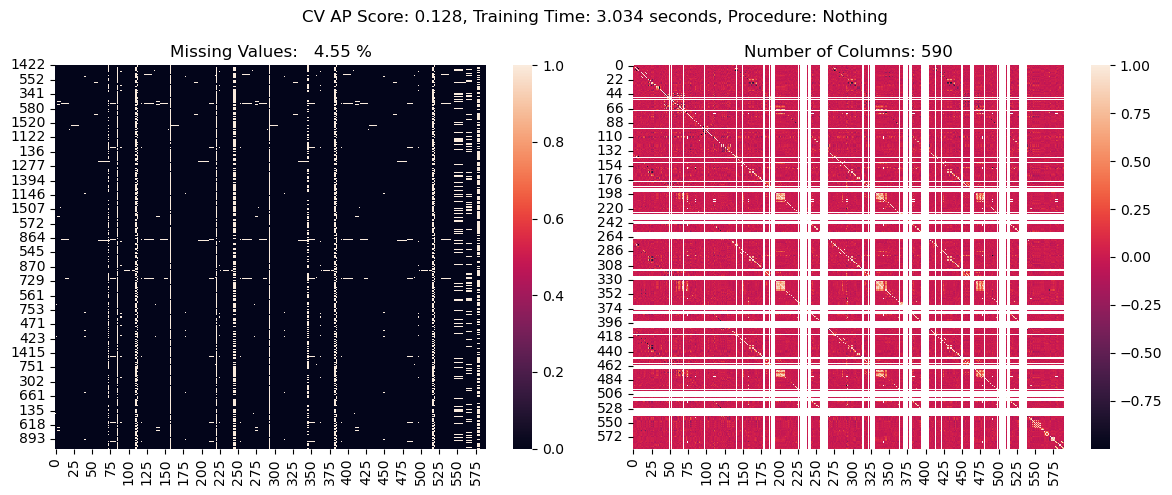

In [35]:
records = info_resume(X_copy, 'Nothing', records)

A considerable amount of missing data, observing entire columns almost completely unrecorded. The average accuracy of the Cross Validation was around 0.128, which is already more than double that of a random classifier, which would classify considering just the proportion of data (0.06). Note that there is spacing in the correlation matrix. This occurs when a feature has no variance, in other words, when it is constant.

## 2. Unsupervised Feature Selection

In this section, we present feature selection approaches that are independent from the target, therefore, unsupervised. 

### 2.1. Drop Constant Features

Constant Features doesn't add any new information,since being a constant value, it doesn't change the slightest when the class change.

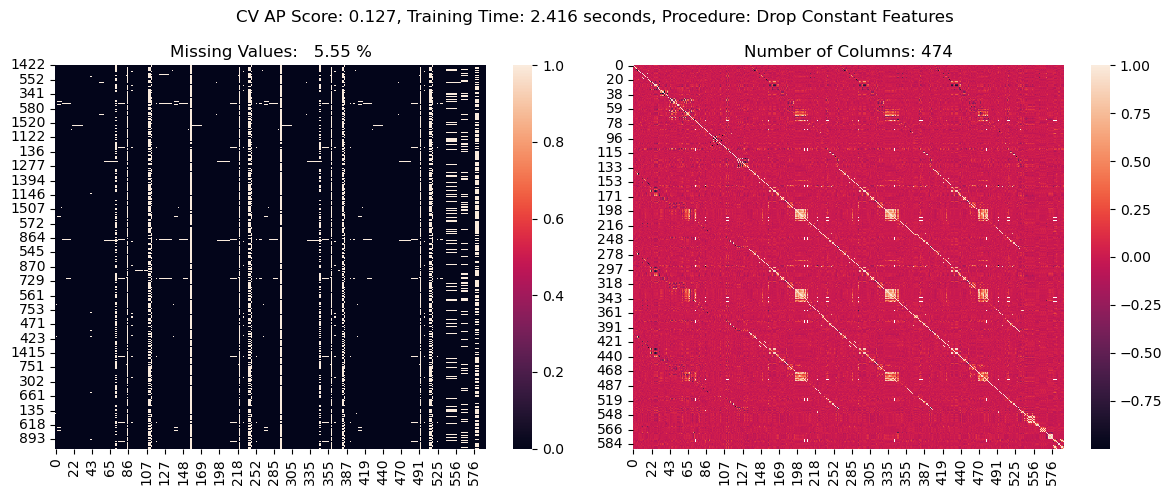

In [36]:
X_copy = DropConstantFeatures(missing_values='ignore').fit_transform(X_copy)

records = info_resume(X_copy, 'Drop Constant Features', records)

There wasn't a significant improvement in precision, but it had in Training Time, reducing it considerably.

### 2.2. Drop Correlated Features

When a feature is correlated with another, it indicates that they may provide similar information or explain the same phenomenon. As a result, keeping both features could lead to redundancy. However, when deciding which feature to drop, we can do it in a thoughtful manner. For this, since the database suffers from missing data, let's use this confirmed: a resource that has more missing data is discarded.

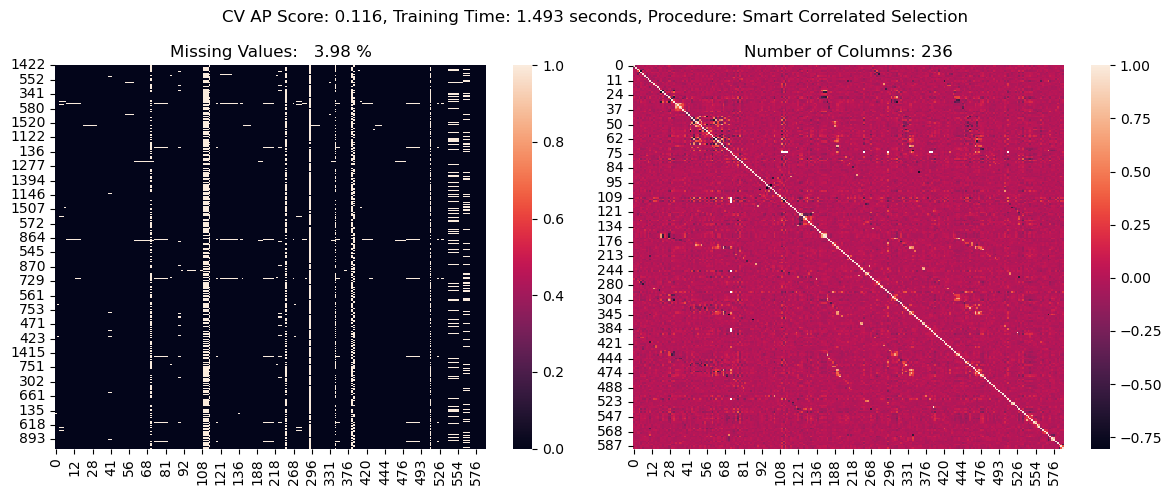

In [37]:
X_copy = SmartCorrelatedSelection(threshold=0.8, selection_method='missing_values').fit_transform(X_copy)

records = info_resume(X_copy, 'Smart Correlated Selection', records)

There is a slight reduction in the performance, but there's also a Training Time reduction by nearly half.

### 2.3. Drop Most Missing Features

Features with too much missing values might not be important to the task accomplishment. Thus, discarding them can be a good strategy in resource selection.

In [38]:
miss_series = X_copy.isnull().sum() / len(X_copy)

miss_series.sort_values(ascending = False).head(22) 

292    0.910615
384    0.646449
109    0.646449
244    0.646449
110    0.646449
111    0.646449
517    0.646449
72     0.512370
345    0.512370
112    0.458899
385    0.458899
569    0.173184
568    0.173184
563    0.173184
562    0.173184
546    0.168396
547    0.168396
548    0.168396
552    0.168396
553    0.168396
554    0.168396
224    0.032721
dtype: float64

Dropping features with more than 10% missing data.

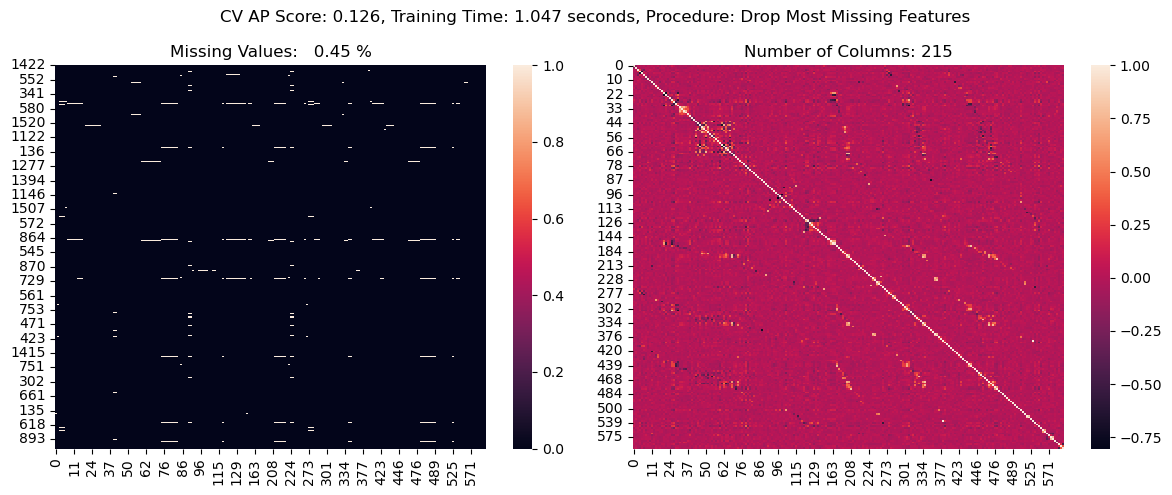

In [39]:
drop_miss = miss_series.loc[miss_series > 0.10]

X_copy = X_copy.drop(drop_miss.index, axis = 1)

records = info_resume(X_copy, 'Drop Most Missing Features', records)

There was a slight increase in performance and a drastic drop in training time. This is likely to be related to the imputation process. The fewer values to be imputed, the faster the automated process.

## 3. Supervised Feature Selection

Now, we will apply aproaches that use information from the target variable, therefore, supervised.

### 3.1. Drop Least Target Correlated

The problem at hand is one of binary classification, therefore, if a feature presents a strong linear correlation with the target, this feature may contain valuable information capable of distinguishing the two classes. If it's too weak, it might just be a noisy feature. Let's look at the distribution of correlations with the target.

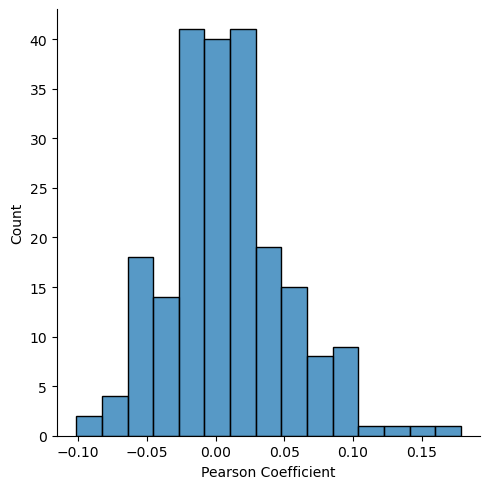

In [11]:
df = pd.concat([X_copy, y], axis = 1)
series = df.corr().iloc[:-1, -1]
series.name = 'Pearson Coefficient'

sns.displot(series, bins = 15);

For feature selection, we drop features with correlations below 0.025. It's important to consider both positive and negative correlations for class distinction.

In [12]:
def pearson_drop(X, y, threshold):
    df = pd.concat([X, y], axis = 1)
    series = df.corr().iloc[:-1, -1]
    series = series.loc[np.abs(series) > threshold] 
    return X.loc[:, series.index]

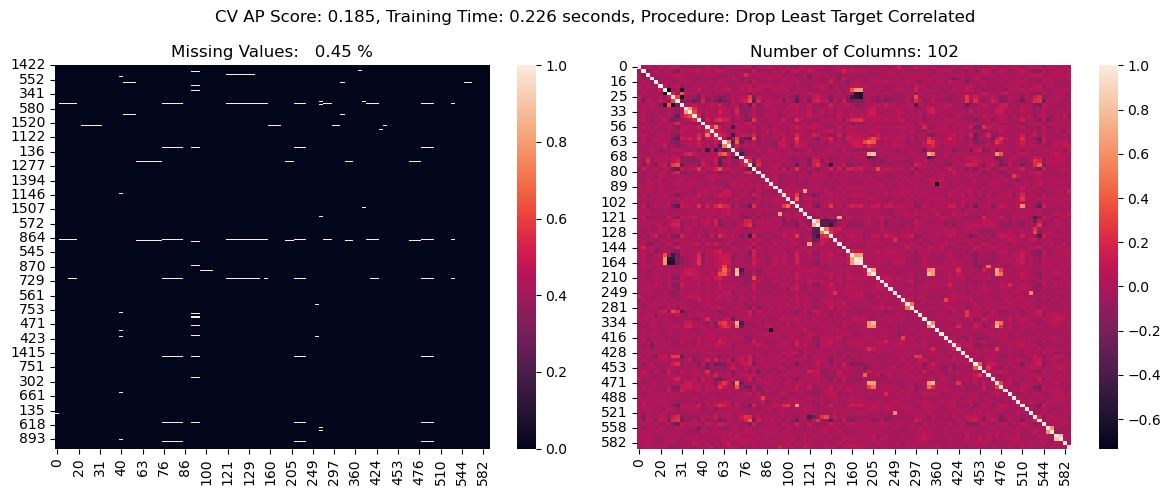

In [13]:
X_copy = pearson_drop(X_copy, y_train, 0.025)

records = info_resume(X_copy, 'Drop Least Target Correlated', records)

We observed significant improvements in both speed and overall performance, with an approximately 50% enhancement. This suggests that the less correlated features were contributing noise to the model.

### 3.2. Recursive Feature Elimination

Recursive Feature Elimination (RFE) is a feature selection technique that aims to identify the most important features in a dataset. It works by recursively eliminating features from the dataset based on their importance or relevance to the target variable. The importance is selected by Logistic Regression coefficients. The process had to be done manually, since the scikit-learn RFE [don't work well with missing data](https://github.com/scikit-learn/scikit-learn/issues/21743).

In [14]:
def recursive_feature_elimination(X, y, kf, verbose = False):
    
    model = pipe_lr.fit(X, y)
    coefs = model.named_steps['estimator'].coef_
    args = np.argsort(np.abs(coefs))
    ord_feats = np.array(X.columns)[args][0]
    X = X.loc[:, ord_feats]
    
    cv_mean = []
    cv_std = []
    
    for i in range(len(X.columns) - 1):
        
        cv_score = cross_val_score(pipe_lr, X, y, cv = kf, scoring = 'average_precision')
        cv_mean.append(cv_score.mean())
        cv_std.append(cv_score.std())
        
        X = X.iloc[:, 1:]
        
        if verbose:
            print(f'Features Evaluated: {i:2d}, score: {cv_score.mean():.3f}')
    
    return np.array(cv_mean[::-1]), np.array(cv_std[::-1]), ord_feats[::-1]

cv_mean, cv_std, ord_feats = recursive_feature_elimination(X_copy, y_train, kf, True)

Features Evaluated:  0, score: 0.185
Features Evaluated:  1, score: 0.185
Features Evaluated:  2, score: 0.186
Features Evaluated:  3, score: 0.185
Features Evaluated:  4, score: 0.187
Features Evaluated:  5, score: 0.192
Features Evaluated:  6, score: 0.192
Features Evaluated:  7, score: 0.188
Features Evaluated:  8, score: 0.196
Features Evaluated:  9, score: 0.194
Features Evaluated: 10, score: 0.194
Features Evaluated: 11, score: 0.193
Features Evaluated: 12, score: 0.196
Features Evaluated: 13, score: 0.197
Features Evaluated: 14, score: 0.197
Features Evaluated: 15, score: 0.198
Features Evaluated: 16, score: 0.199
Features Evaluated: 17, score: 0.200
Features Evaluated: 18, score: 0.202
Features Evaluated: 19, score: 0.205
Features Evaluated: 20, score: 0.212
Features Evaluated: 21, score: 0.209
Features Evaluated: 22, score: 0.211
Features Evaluated: 23, score: 0.215
Features Evaluated: 24, score: 0.211
Features Evaluated: 25, score: 0.203
Features Evaluated: 26, score: 0.202
F

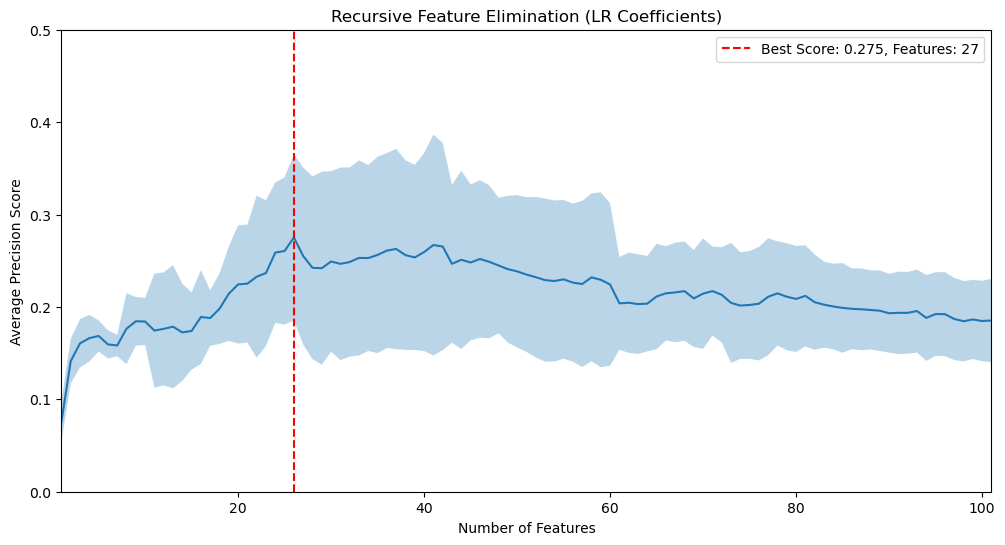

In [15]:
arg = np.argmax(cv_mean)
max_ap = np.max(cv_mean)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(range(1, len(ord_feats)), cv_mean)
ax.fill_between(range(1, len(ord_feats)), cv_mean - cv_std, cv_mean + cv_std, alpha = 0.3)
ax.set_xlim(1, 101)
ax.set_ylim(0, 0.5)
ax.axvline(arg+1, ls = '--', color = 'r', label = f'Best Score: {max_ap:.3f}, Features: {arg+2}')
ax.set_ylabel('Average Precision Score')
ax.set_xlabel('Number of Features')
ax.grid(False)
ax.set_title('Recursive Feature Elimination (LR Coefficients)')
ax.legend();

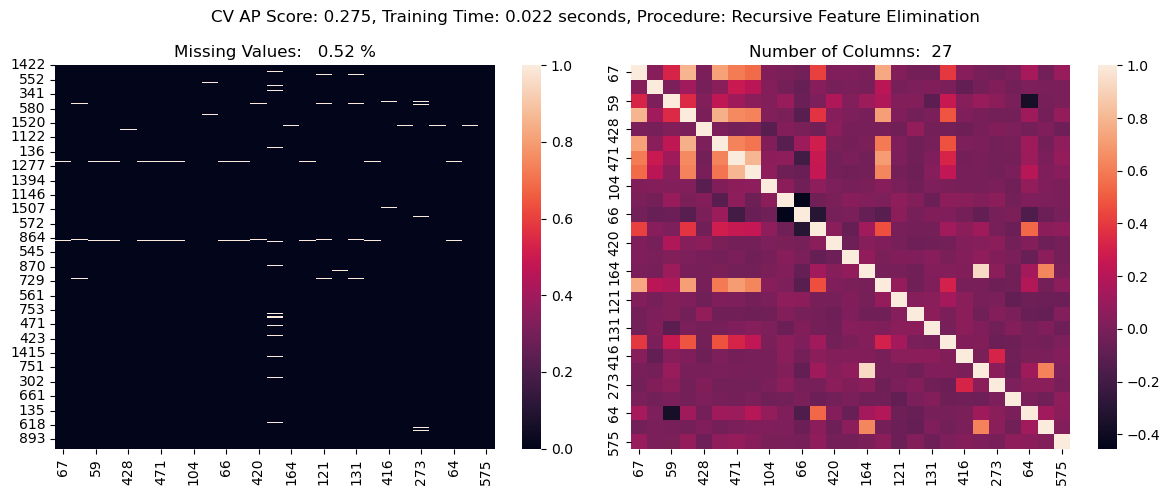

In [16]:
X_copy = X_train.loc[:, ord_feats[:arg+2]]

records = info_resume(X_copy, 'Recursive Feature Elimination', records);

There is strong increase in overall performance and decrease in training time, since now, informed by the target, the best features were selected. 

## 4. Hyperparameter Optimization

The next step is to optimize the hyperparameters that were initially set before the feature selection process. To achieve this, we employ a Randomized Search approach to explore the best combination of hyperparameters. Specifically, we focus on tuning the parameters C, class weight, and the number of neighbors.

In [17]:
selected_feats = X_copy.columns

X_train = X_train.loc[:, selected_feats]
X_test = X_test.loc[:, selected_feats]


p_dist1 = {'estimator__C': np.logspace(-1, 2, 100),
          'imputer__n_neighbors': np.linspace(15, 50, 20, dtype = int),
          'estimator__class_weight': [{0: 1, 1: w} for w in np.linspace(10, 60, 100)]
         }

search1 = RandomizedSearchCV(pipe_lr, p_dist1, n_iter = 400, cv = kf, verbose=False, scoring = 'average_precision')

In [18]:
search1.fit(X_train, y_train);

In [19]:
df_cv_results1 = pd.DataFrame(search1.cv_results_)

df_cv_results1['class_weight'] = df_cv_results1['param_estimator__class_weight'].apply(lambda x: x[1])

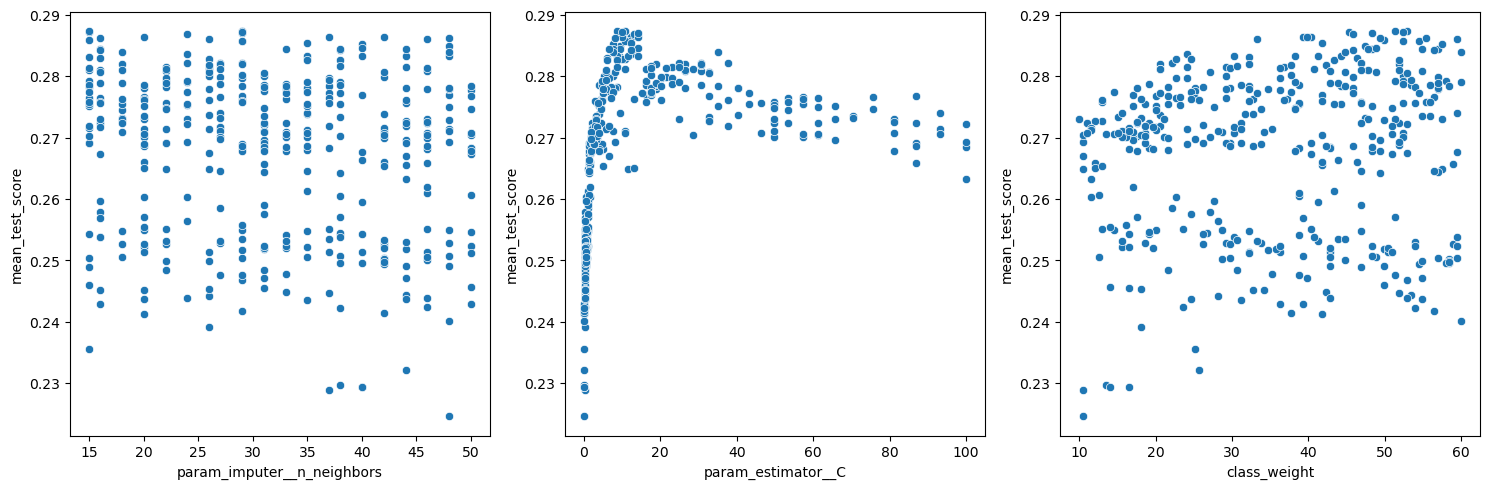

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(data = df_cv_results1, 
                x = 'param_imputer__n_neighbors', 
                y = 'mean_test_score', ax = ax[0])
sns.scatterplot(data = df_cv_results1,
                x = 'param_estimator__C',
                y = 'mean_test_score', ax = ax[1])
sns.scatterplot(data = df_cv_results1,
                x = 'class_weight',
                y = 'mean_test_score', ax = ax[2])

fig.tight_layout()

In [21]:
best = search1.best_params_

best

{'imputer__n_neighbors': 15,
 'estimator__class_weight': {0: 1, 1: 52.929292929292934},
 'estimator__C': 8.697490026177835}

Observing the distribution diagrams, it is seen that the number of neighbors does not have a very significant impact, with its highest validation results in values below 27. As for parameter C, a clear convergence to values around of 10, increasing the performance as C is increased. For the class weight, there is a tendency for performance to increase until it stabilizes after a value of 40.

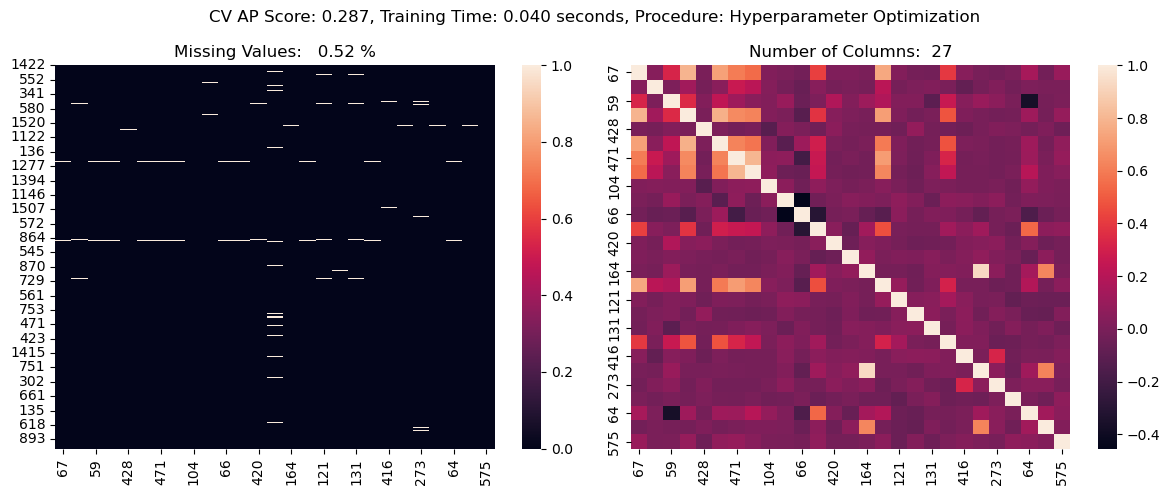

In [22]:
pipe_lr = Pipeline(steps = [
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors = best['imputer__n_neighbors'])),
    ('estimator', LogisticRegression(penalty = 'l2', 
                                     solver = 'liblinear', 
                                     max_iter = int(1e5),
                                     C = best['estimator__C'],
                                     class_weight = best['estimator__class_weight']))
])

records = info_resume(X_train, 'Hyperparameter Optimization', records)

There was a slight drop in training time and a notable increase in performance, but not as much as the feature selection techniques.

## 5. Model Evaluation

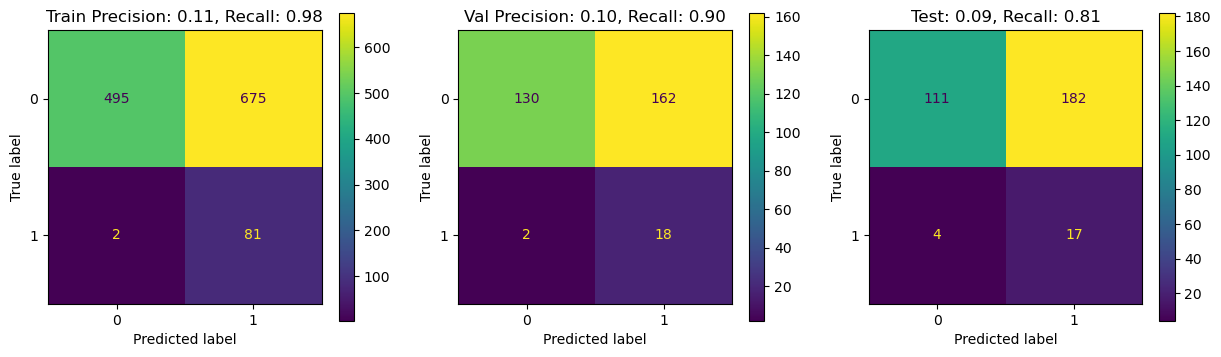

In [23]:
cm_val = 0

for train_index, val_index in kf.split(X_train, y_train):
    
    X_par_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_par_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index] 
    
    pipe_lr.fit(X_par_train, y_par_train)
    y_pred_val = pipe_lr.predict(X_val)

    cm_val += cm(y_val, y_pred_val)
    
pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)
y_pred_train = pipe_lr.predict(X_train)

cm_test = cm(y_test, y_pred)
cm_train = cm(y_train, y_pred_train)
    
cm_val //= 4

val_precision = cm_val[1, 1] / (cm_val[1, 1] + cm_val[0, 1]) 
train_precision = cm_train[1, 1] / (cm_train[1, 1] + cm_train[0, 1])
test_precision = cm_test[1, 1] / (cm_test[1, 1] + cm_test[0, 1])

val_recall = cm_val[1, 1] / (cm_val[1, 1] + cm_val[1, 0]) 
train_recall = cm_train[1, 1] / (cm_train[1, 1] + cm_train[1, 0])
test_recall = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

fig, ax = plt.subplots(1, 3, figsize = (15, 4))

plot1 = ConfusionMatrixDisplay(cm_train)
plot2 = ConfusionMatrixDisplay(cm_val)
plot3 = ConfusionMatrixDisplay(cm_test)

plot1.plot(ax = ax[0]) 
plot2.plot(ax = ax[1])
plot3.plot(ax = ax[2]);

ax[0].set_title(f'Train Precision: {train_precision:.2f}, Recall: {train_recall:.2f}')
ax[1].set_title(f'Val Precision: {val_precision:.2f}, Recall: {val_recall:.2f}')
ax[2].set_title(f'Test: {test_precision:.2f}, Recall: {test_recall:.2f}');

We can see that the imbalance is affecting the performance of the model. There is a considerable amount of false alarms which is proportionally much higher than the number of true positives, occuring low precision. However, we have good sensitivity, with very few false negatives. In the context of fault detection, false negatives are more harmful, since you are letting failures pass, potentially incurring catastrophic events. The validation and test values are close, leading to the conclusion that the applied validation process is well representative for unseen values. It is worth mentioning that these classifications are defined by a threshold of 0.5. 

In [24]:
val_scores = []
val_labels = []

for train_index, val_index in kf.split(X_train, y_train):
    
    X_par_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_par_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    pipe_lr.fit(X_par_train, y_par_train)
    val_score = pipe_lr.predict_proba(X_val)[:, 1]
    
    val_scores.append(val_score)
    val_labels.append(y_val)
    
pipe_lr.fit(X_train, y_train)

test_scores = pipe_lr.predict_proba(X_test)[:, 1]
train_scores = pipe_lr.predict_proba(X_train)[:, 1]
    
val_scores = np.concatenate(val_scores)
val_labels = np.concatenate(val_labels)

fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
fpr_val, tpr_val, _ = roc_curve(val_labels, val_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)

pre_train, rec_train, _ = precision_recall_curve(y_train, train_scores)
pre_val, rec_val, _ = precision_recall_curve(val_labels, val_scores)
pre_test, rec_test, _ = precision_recall_curve(y_test, test_scores)

auc_train = roc_auc_score(y_train, train_scores)
ap_train = average_precision_score(y_train, train_scores)

auc_val = cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'roc_auc').mean()
ap_val = cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'average_precision').mean()

auc_test = roc_auc_score(y_test, test_scores)
ap_test = average_precision_score(y_test, test_scores)


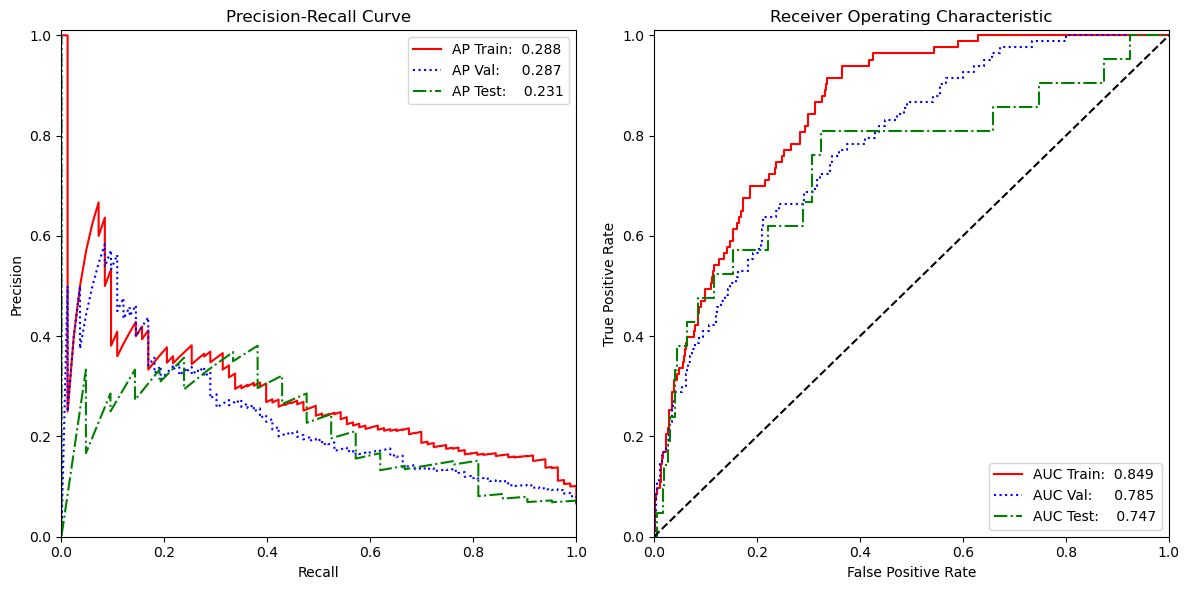

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))


ax[0].plot(rec_train, pre_train, label = f'AP Train:{ap_train:7.3f}', ls = '-', color = 'r')
ax[0].plot(rec_val, pre_val, label = f'AP Val:   {ap_val:7.3f}', ls = ':', color = 'b')
ax[0].plot(rec_test, pre_test, label = f'AP Test:  {ap_test:7.3f}', ls = '-.', color = 'g')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1.01)
ax[0].legend()
ax[0].set_title('Precision-Recall Curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')

ax[1].plot(fpr_train, tpr_train, label = f'AUC Train:{auc_train:7.3f}', ls = '-', color = 'r')
ax[1].plot(fpr_val, tpr_val, label = f'AUC Val:   {auc_val:7.3f}', ls = ':', color = 'b')
ax[1].plot(fpr_test, tpr_test, label = f'AUC Test:  {auc_test:7.3f}', ls = '-.', color = 'g')
ax[1].plot([0, 1], [0, 1], ls = '--', color = 'k')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1.01)
ax[1].legend()
ax[1].set_title('Receiver Operating Characteristic')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate');

fig.tight_layout()

When looking at the average precision and ROC curves for each data set, we noticed something important. It is evident that the ROC curve can give us the wrong impression of an excellent performance, especially when dealing with unbalanced data. This is because the significant presence of false positives decreases the overall accuracy of the model, making it necessary to consider other metrics, such as average accuracy, which takes into account the distribution of classes and offers a more accurate view of performance in unbalanced problems.

* [The Relationship Between Precision-Recall and ROC Curves](https://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)
* [ROC vs Precision-recall curves on imbalanced dataset](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)
* [ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

## 5. Conclusion

Text(0, 0.5, 'Training Time [seconds]')

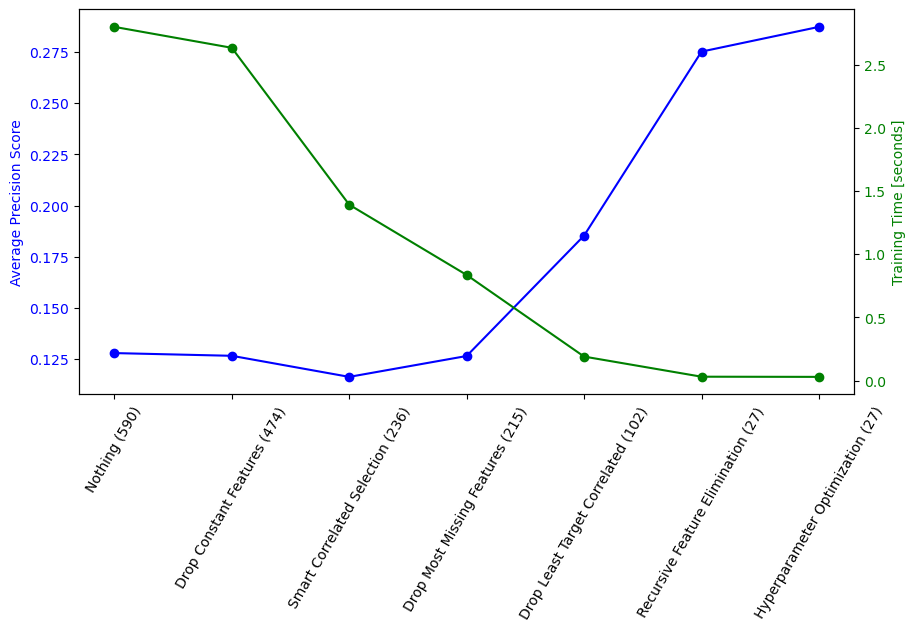

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.plot(records['procedure'], records['cv_ap_score'], marker = 'o', color = 'b')
ax.tick_params(axis='x', labelrotation=60)
ax.tick_params(axis='y', labelcolor='b')
ax.set_ylabel('Average Precision Score', color='b')

ax2 = ax.twinx()

ax2.plot(records['procedure'], records['training_time'], marker = 'o', color = 'g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('Training Time [seconds]', color='g') 

By analyzing the curves, we can see that there is no significant increase in model performance when applying unsupervised feature selection methods. In fact, eliminating correlated features can even result in a drop in performance. However, there is a significant reduction in training time, which speeds up supervised feature selection methods, especially on high dimensional datasets like the present one. The greatest performance gain was obtained with the application of Recursive Feature Elimination (RFE), surpassing even the hyperparameter optimization process. This leads us to the conclusion that preprocessing is indispensable in Machine Learning applications, highlighting the importance of proper feature selection to achieve optimal results.

In [27]:
with open('features_selected.txt', 'w') as f:
    for c in X_train.columns:
        f.write(str(c))
        f.write('\n')